In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from pandas import Series, DataFrame
import torch
from torch.utils.data import Dataset
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
from tensorflow.keras.applications import EfficientNetB0

In [2]:
for dirname, _, filenames in os.walk(r"C:\Users\manju\Downloads\ML projects\ROP\Retinaimg"):
   for filename in filenames:
    x=Image.open(os.path.join(dirname, filename))
    print('File Name',os.path.join(dirname, filename))
    print('Picture Size', x.size)

File Name C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\NoROP_Patient1.jpg
Picture Size (1600, 1200)
File Name C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\NoROP_Patient10.jpg
Picture Size (1600, 1200)
File Name C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\NoROP_Patient10_2.jpg
Picture Size (1600, 1200)
File Name C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\NoROP_Patient10_2_eye2.jpg
Picture Size (1600, 1200)
File Name C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\NoROP_Patient11.jpg
Picture Size (1600, 1200)
File Name C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\NoROP_Patient12.jpg
Picture Size (1600, 1200)
File Name C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\NoROP_Patient13.jpg
Picture Size (1600, 1200)
File Name C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\NoROP_Patient14.jpg
Picture Size (1600, 1200)
File Name C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\NoROP_Patient15.jpg
Picture Size (1600, 1200)
File Name C:\Users\manju\Down

In [3]:
#Assign the used device to GPU if available
device = ("cuda" if torch.cuda.is_available() else "cpu")

#Creation of the Dataframe
train_df = pd.DataFrame(columns=["img_name","label"])

#Assign each images from the input folder to a label corresponding to ROP or No ROP
train_df["img_name"] = os.listdir(r"C:\Users\manju\Downloads\ML projects\ROP\Retinaimg")
for idx, i in enumerate(os.listdir("C:/Users/manju/Downloads/ML projects/ROP/Retinaimg")):
    '''Here we give a label for ROP/No ROP to every images depending on the name they have (the stage they correspond to) '''
    if "NoROP" in i:
        train_df["label"][idx] = 0
    if "Stage1" in i:
        train_df["label"][idx] = 1
    if "Stage2" in i:
        train_df["label"][idx] = 2
    if "Stage3" in i:
        train_df["label"][idx] = 3

#View the dataframe created
print(train_df)

#Create a csv file out of our dataframe
train_df.to_csv (r'train_csv.csv', index = False, header=True)

                      img_name label
0           NoROP_Patient1.jpg     0
1          NoROP_Patient10.jpg     0
2        NoROP_Patient10_2.jpg     0
3   NoROP_Patient10_2_eye2.jpg     0
4          NoROP_Patient11.jpg     0
..                         ...   ...
86         Stage3_Patient5.jpg     3
87         Stage3_Patient6.jpg     3
88         Stage3_Patient7.jpg     3
89         Stage3_Patient8.jpg     3
90         Stage3_Patient9.jpg     3

[91 rows x 2 columns]


In [5]:
train_df.head(90)

,img_name,label
0,NoROP_Patient1.jpg,0
1,NoROP_Patient10.jpg,0
2,NoROP_Patient10_2.jpg,0
3,NoROP_Patient10_2_eye2.jpg,0
4,NoROP_Patient11.jpg,0
...,...,...
85,Stage3_Patient4.jpg,3
86,Stage3_Patient5.jpg,3
87,Stage3_Patient6.jpg,3
88,Stage3_Patient7.jpg,3


In [18]:
#Create a list to make classes label explicite
classes=['No ROP','Stage1','Stage2','Stage3']
for label_number in range(4):
    print('Label',label_number,'corresponds to',classes[label_number])

Label 0 corresponds to No ROP
Label 1 corresponds to Stage1
Label 2 corresponds to Stage2
Label 3 corresponds to Stage3


In [19]:
#Create a list of labels from our data frame
ListOfLabels=train_df["label"].to_list()

#Here we are gonna count how many images for each stages we have
#No ROP
NoROP_Size=ListOfLabels.count(0)
print('Number of NoROP images', NoROP_Size)

#ROP Stage1
Stage1_Size=ListOfLabels.count(1)
print('Number of Stage1 images', Stage1_Size)

#ROP Stage2
Stage2_Size=ListOfLabels.count(2)
print('Number of Stage2 images', Stage2_Size)

#ROP Stage3
Stage3_Size=ListOfLabels.count(3)
print('Number of Stage3 images', Stage3_Size)
print('the size of our dataset is',len(train_df["label"]))

Number of NoROP images 39
Number of Stage1 images 19
Number of Stage2 images 22
Number of Stage3 images 11
the size of our dataset is 91


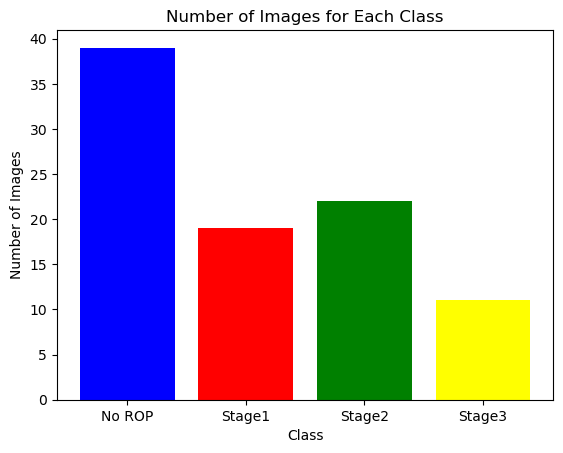

In [23]:
import matplotlib.pyplot as plt
label_counts = {'No ROP': NoROP_Size, 'Stage1': Stage1_Size,'Stage2': Stage2_Size,'Stage3': Stage3_Size}
plt.bar(label_counts.keys(), label_counts.values(), color=['blue', 'red','green','yellow'])
plt.title('Number of Images for Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


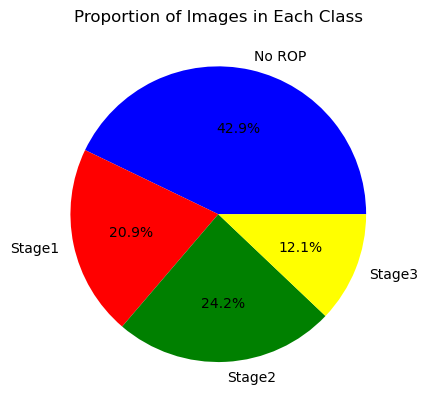

In [24]:
# Create a pie chart
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', colors=['blue', 'red','green','yellow'])
plt.title('Proportion of Images in Each Class')
plt.show()


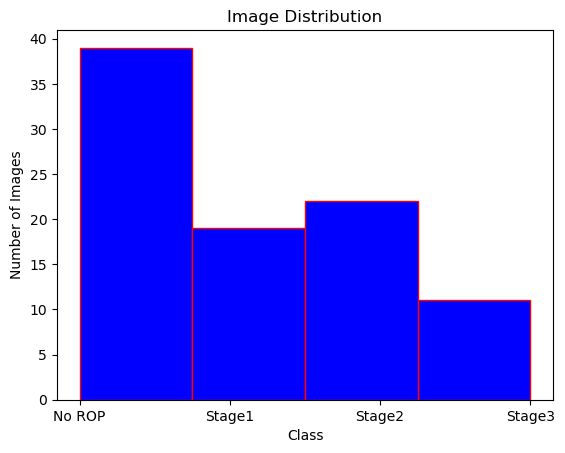

In [28]:
# Create a histogram with one color per class
plt.hist(ListOfLabels, bins=4, edgecolor='red', color='blue')  # Single color for the whole dataset
plt.xticks([0, 1,2,3], ['No ROP', 'Stage1','Stage2','Stage3'])
plt.title('Image Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [29]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the path to your images
image_folder = r"C:\Users\manju\Downloads\ML projects\ROP\Retinaimg"

# Get the list of all image filenames
all_images = os.listdir(image_folder)

# Create a DataFrame with image filenames and labels
image_labels = []
for img in all_images:
    label = 0 if "NoROP" in img else 1  # Modify based on your naming convention
    image_labels.append((img, label))

df = pd.DataFrame(image_labels, columns=["img_name", "label"])

# Split into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the DataFrames to CSV
train_df.to_csv('train_csv.csv', index=False)
test_df.to_csv('test_csv.csv', index=False)

print("CSV files for train and test sets created.")


CSV files for train and test sets created.


In [30]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224
    transforms.RandomHorizontalFlip(),    # Random horizontal flip
    transforms.RandomRotation(10),        # Random rotation
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (ImageNet stats)
])

# Custom Dataset Class
class ROPDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Dataset and DataLoader
train_dataset = ROPDataset(train_df, image_folder, transform=transform)
test_dataset = ROPDataset(test_df, image_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [31]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load EfficientNetB0 pre-trained model
model = models.efficientnet_b0(pretrained=True)

# Modify the final layer for 4 classes
num_classes = 4
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


C:\Users\manju\anaconda3\New folder\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\manju\anaconda3\New folder\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\manju/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:10<00:00, 1.99MB/s]


In [32]:
# Training and Validation Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100. * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


Epoch 1/10, Loss: 3.4474, Accuracy: 44.44%
Epoch 2/10, Loss: 1.8861, Accuracy: 83.33%
Epoch 3/10, Loss: 0.6574, Accuracy: 93.06%
Epoch 4/10, Loss: 0.6260, Accuracy: 97.22%
Epoch 5/10, Loss: 0.3603, Accuracy: 95.83%
Epoch 6/10, Loss: 0.3866, Accuracy: 95.83%
Epoch 7/10, Loss: 0.2365, Accuracy: 98.61%
Epoch 8/10, Loss: 0.5129, Accuracy: 93.06%
Epoch 9/10, Loss: 1.2275, Accuracy: 97.22%
Epoch 10/10, Loss: 0.6887, Accuracy: 91.67%


In [35]:
torch.save(model.state_dict(), 'rop_model.pth')
print("Model saved as rop_model.pth")


Model saved as rop_model.pth


In [47]:
from PIL import Image
import torchvision.transforms as transforms

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image_path = r"C:\Users\manju\Downloads\ML projects\ROP\Retinaimg\Stage2_Patient1.jpg"
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension

# Move to device and predict
image = image.to(device)
output = model(image)
_, predicted = output.max(1)

# Map predictions to class names
classes = ['No ROP', 'Stage 1', 'Stage 2', 'Stage 3']
print(f"The model predicts: {classes[predicted.item()]}")


The model predicts: Stage 1
